# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "el_alaoui"
fn2 = "chia_man"
ln2 = "hung"
fn3 = "zhengying"
ln3 = "liu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2, "and", ln3, fn3])) + ".ipynb"
print(filename)

project_el_alaoui_salma_and_hung_chia_man_and_liu_zhengying.ipynb


Some imports

In [3]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

- A1: We can rewrite the problem as
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} J(w,b)
 \\
  &F_i(w,b)\leq 0, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$
where $J(w,b)=\frac{1}{2}w^{\top}w$ and $F_i(w,b)=1-y_{i}(w^{\top}x_{i}+b)$. We see that $J(w)$ is quadratic and definite positive thus convex. $F_i(w)$ are affine and thus convex too.

In conclusion, the problem $(\mathcal{P})$ is convex.

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

- A2: 
The Lagrangian is given by
$$
L(w,b,\mu) = J(w,b)+\mu \cdot F(w,b)
$$
Because $\mathcal{P}$ is convex (by Q1), and the constaints are qualified, by applying the KKT theorem, there exists saddle points $(w^{*}, \mu^{*})$ such that $w^{*}$ are solutions to the primal problem and $\mu^{*}$ are solutions to the dual problem. The dual problem reads:
$$
\begin{cases}
\max_{\mu} H(\mu) \\
\mu \geq 0
\end{cases}
$$
where
$$
H(\mu) = \min_{w,b} L(w,b,\mu)
$$
To get the explicit formula of $H$ we have
$$
\begin{cases}
\frac{\partial}{\partial w} L(w,b,\mu) = 0 \\
\frac{\partial}{\partial b} L(w,b,\mu) = 0
\end{cases}
$$
from which we have
$$
\begin{cases}
w - G^\top \mu = 0 \\
- \mu \cdot y = 0
\end{cases}
$$
Then for $H$ we have
$$
H(\mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu \cdot (u - G G^\top \mu - y) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu ^\top u
$$
Thus the dual problem can be written as
$$
(\mathcal{D}):
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
y^\top \mu = 0\\
-\mu \leq 0
\end{cases}
$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

- A3:
From Q2 we have
$$w = G^\top \mu$$
where $G^\top = [y_1 x_1,...,y_n x_n]$. Thus
$$ w = \sum_{i=1}^n \mu_i y_i x_i$$
And the prediction function $f(x)=\mathrm{sign}(w^{\top}x + b)$ is then given by
$$
f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [4]:
from svm_project_utils import plot_dataset, datasets

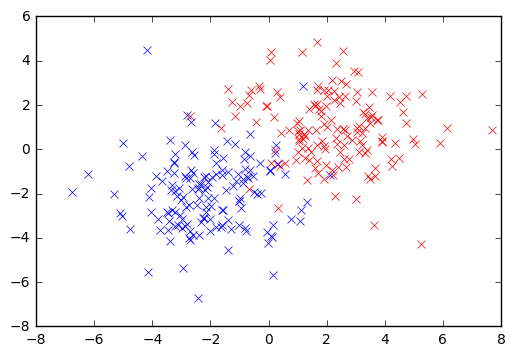

In [5]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [6]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [7]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


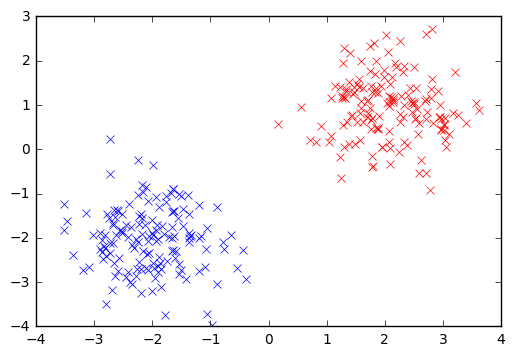

In [8]:
n = 300
X, y = datasets(name='gaussian', n_points=n, sigma=0.7)
plot_dataset(X, y)

def svm_solver(K, y, C=np.inf):
    H = (y * K).T * y
    e = np.ones(y.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [9]:
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

- A6: 

According to the complementary slackness KKT condition, we have: 
$ \mu_j(y_{j}(w^{t}x_{j}+b) - 1) = 0 $ for all data points j.

For all support vectors i we have $\mu_i > 0$ and therefore $y_{i}(w^{t}x_{i}+b) - 1 = 0$

Since $y_i\in\{-1,+1\}$:

$$ b = y_i - w^{t}x_{i} $$

and we have that $w = G^{T}\mu = \sum_{i=1}^{n} y_j \mu_j x_j$, therefore: 

$$b = y_i - \sum_{i=1}^{n} y_j \mu_j x_j^T x_i$$ where $i$ is a support vector.

In [10]:
def compute_b(K, y, mu_support, idx_support):
    mu = np.zeros(K.shape[0])
    mu[idx_support] = mu_support
    i = idx_support[0]
    y_i = y[i] 
    #b = y_i - np.sum((y * mu)* K[i, :], axis = 0)
    b = y_i - np.sum((y[idx_support] * mu_support) * K[i, idx_support], axis = 0)
    return b

b = compute_b(K, y, mu_support, idx_support)

- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [11]:
positive = y * (np.dot(X, w) + b*np.ones(n)) - 1 + 1e-5
print(np.all(positive >= 0))

True


Check your code by running the following cell:

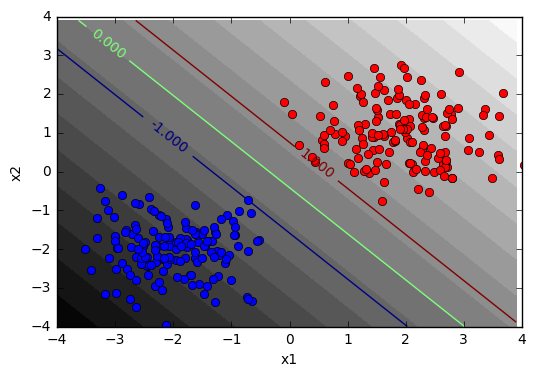

In [12]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

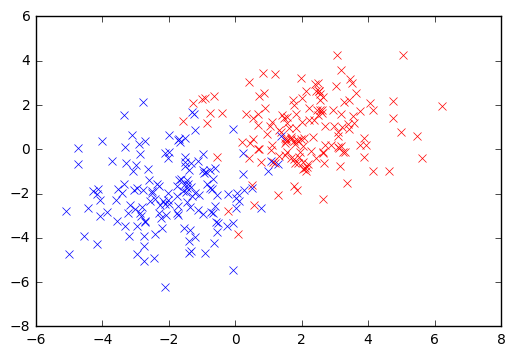

In [13]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [14]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

Terminated (singular KKT matrix).


- Q8: Check that contraints of the problem are now violated.

In [15]:
positive = y * (np.dot(X, w) + b*np.ones(n)) - 1 + 1e-5
print(np.all(positive >= 0))

False


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + b) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

- A9: Again, the loss function $J(w,b,\xi) = \frac{1}{2} w^\top w + C \sum_i \xi_i$ is quadratic and semi-definite positive and is thus convex. On the other hand, the constraint functions $1 - \xi_i - y_i(w^\top x_i + b)$ and $-\xi$ are all affine and thus convex too. So, the problem $(P_s)$ is a convex problem.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- 
The Lagrangian is given by
$$
L(w,b,\xi,\mu,\nu) = \frac{1}{2} w^\top w + C\sum_i \xi_i + \sum_i \mu_i(1 - \xi_i - y_i (w^\top x_i +b)) + \sum_i \nu_i (-\xi_i)
$$
and the dual problem reads
$$
\begin{cases}
\max_{\mu, \nu} H(\mu,\nu) \\
\mu \geq 0 \\
\nu \geq 0
\end{cases}
$$
where
$$
H(\mu, \nu) = \min_{w,b,\xi} L(w,b,\xi,\mu,\nu)
$$
To get the explicit formula of $H$ we have
$$
\begin{cases}
\frac{\partial}{\partial w} L(w,b,\xi,\mu,\nu) = 0 \\
\frac{\partial}{\partial b} L(w,b,\xi,\mu,\nu) = 0 \\
\frac{\partial}{\partial \xi} L(w,b,\xi,\mu,\nu) = 0
\end{cases}
$$
from which we have
$$
\begin{cases}
w - G^\top \mu = 0 \\
- \mu \cdot y = 0 \\
C\mathbb{1} - \mu - \nu = 0
\end{cases}
$$
Then for $H$ we have
$$
H(\mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu \cdot (u - G G^\top \mu - y) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu ^\top u
$$
Thus the dual problem can be written as
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
y^\top \mu = 0\\
\mu \geq 0 \\
\nu \geq 0 \\
\mu + \nu = C \mathbb{1}
\end{cases}
$$
which is equivalent to 
$$
(\mathcal{D}):
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
y^\top \mu = 0\\
0 \leq \mu \leq C \\
\end{cases}
$$

- Q10: Modify your code from Q4 to handle the non-separable case.

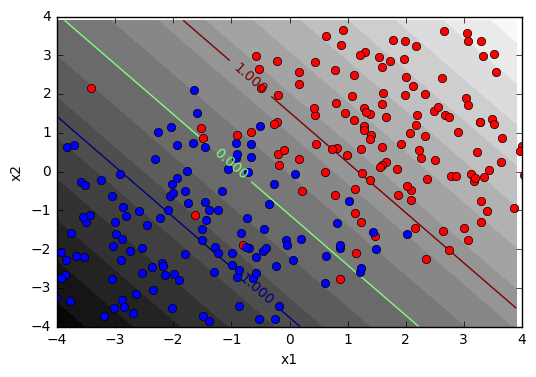

In [16]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=0.01)
b = compute_b(K, y, mu_support, idx_support)
plot_classif(X, y, mu_support, idx_support, b)

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

<font color='red'>  **TODO question 11** </font>

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

- A12:
With $K(x_i,x_j)$, the dual problem becomes
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j K(x_i,x_j) - \mu ^\top u \\
y^\top \mu = 0\\
0 \leq \mu \leq C \\
\end{cases}
$$
and the prediction function becomes
$$
f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) + b) \enspace .
$$

We will use the clowns dataset to evaluate this:

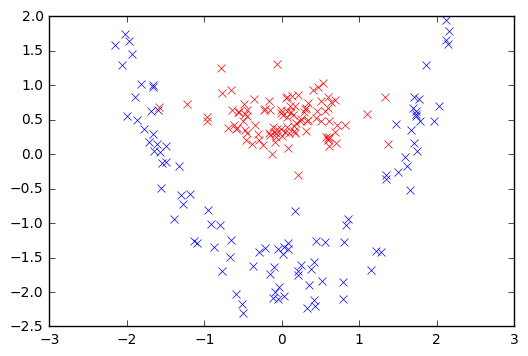

In [17]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [18]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*np.linalg.norm(X1[i] - X2[j]))  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

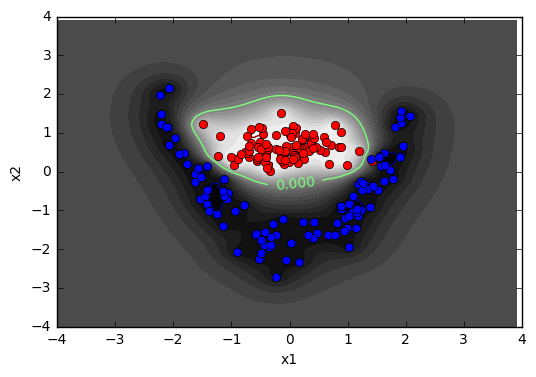

In [19]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- A14:
The Lagrangian is given by
$$
L(w,\xi,\mu,\nu) = \frac{1}{2} w^\top w + C\sum_i \xi_i + \sum_i \mu_i(1 - \xi_i - y_i w^\top x_i) + \sum_i \nu_i (-\xi_i)
$$
and the dual problem reads
$$
\begin{cases}
\max_{\mu, \nu} H(\mu,\nu) \\
\mu \geq 0 \\
\nu \geq 0
\end{cases}
$$
where
$$
H(\mu, \nu) = \min_{w,\xi} L(w,\xi,\mu,\nu)
$$
To get the explicit formula of $H$ we have
$$
\begin{cases}
\frac{\partial}{\partial w} L(w,\xi,\mu,\nu) = 0 \\
\frac{\partial}{\partial \xi} L(w,\xi,\mu,\nu) = 0
\end{cases}
$$
from which we have
$$
\begin{cases}
w - G^\top \mu = 0 \\
C\mathbb{1} - \mu - \nu = 0
\end{cases}
$$
Then for $H$ we have
$$
H(\mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu \cdot (u - G G^\top \mu - y) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu ^\top u
$$
Thus the dual problem can be written as
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
\mu \geq 0 \\
\nu \geq 0 \\
\mu + \nu = C \mathbb{1}
\end{cases}
$$
which is equivalent to 
$$
(\mathcal{D}):
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top 1_n \\
0 \leq \mu \leq C \\
\end{cases}
$$

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

- A15:
We write 
$$f(\mu) = \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top 1_n $$
and 
$$
g(\mu) = \sum_{i=1}^n g_i (\mu_i)
$$
where
$$
g_i(\mu_i) = \mathbb{I}_{[0,C]}(\mu_i) = 
\begin{cases}
0, \quad \text{if } \mu_i \in [0,C] \\
+\infty, \quad \text{if } \mu_i \not \in [0,C]
\end{cases}
$$
Then the problem $(\mathcal{D})$ can be written in the form:
$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu).
$$
$f$ is a quadratic form and :
$$
\nabla f (\mu) = GG^T \mu - 1_n
$$
$$
\nabla^2 f(\mu) = GG^T
$$
We see that $f$ is $L$-smooth where
$$
L = \| G G^\top \|_{op}
$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

In [20]:
from scipy.optimize import fmin_l_bfgs_b
